# Tracing simulator

In [1]:
from simulator.application import *
from simulator.infrastructure import *
from simulator.simulation import *
from simulator.runtime import *
from agents.agents import *

#MAXSUBTASKS = 10
#COMM_PROB = 0.2
#LOADMAX = 7000
#LOADMIN = 1000
#MEMMAX = 1
#SIGMA = 0.05
#MAXTASKS = 4
#MAXTASKTREES = 1
#MAXSERVICES = 3
#MAXLENGTH = 8
#MAXLAMBDA = 1.0/5
#CPUMAX = 8
RAMMAX = 8
FREQMAX = 1000
#QMAX = 100
TIMEOUT = 600000
#DEBUG = False

In [2]:
# APP INITIALIZATION

app = Application(3,1)
#a = app.task_graph
#draw_graph(a,[a.nodes[x]["subset"] for x in a.nodes],1)
#b = app.service_graph
#draw_graph(b,[x for x in b.nodes],2)

Services: 3
Tasktrees: 1
[0, 1]
Labels: {0: 1, 1: 0}


In [15]:
# INFRASTRUCTURE INITIALIZATION
replicas = [4,4,4]

# Create nodes
nodes = [VirtualMachine(cc,replicas[i],RAMMAX,FREQMAX) for i,cc in enumerate(app.services)]

# Service placement
map = {}
for s,cc in zip(app.services,nodes):
    map[s.id] = nodes[0]
app.deploy_services(map)
# Service threads
for i,s in enumerate(app.services):
    s.threads = replicas[i]

In [4]:
# AGENTS INITIALIZATION

agents = []
agents.append(ServiceAgent(random=False))
agents.append(ServiceAgent(random=False))

In [16]:
# RUN SIMULATION
ITERATIONS = 100
STEPS = 1
STEP_SIZE = ITERATIONS / STEPS
AGENT_STEP_SIZE = 1
AGENT_STEPS = ITERATIONS / AGENT_STEP_SIZE

LATMIN = [40,15]

ALLOC_METHOD = 0
REPLAY = False
DEBUG = True

# Reset agents
if ALLOC_METHOD == 1:
    for a in agents:
        a.reset_environment()

# Reset app status
H = None
if REPLAY:
    H = app.get_history()
app.reset(H)

# Run simulation
sim = Simulation([app],[],ITERATIONS,STEP_SIZE,AGENT_STEP_SIZE,TIMEOUT)
if ALLOC_METHOD == 1:
    sim.run(agents)
    for a in agents:
        rewards = moving_average(a.rewards,int(STEP_SIZE/AGENT_STEP_SIZE))
        plt.plot(range(len(rewards)), rewards)
        plt.show()
else:
    sim.run()

Success rate: 100%


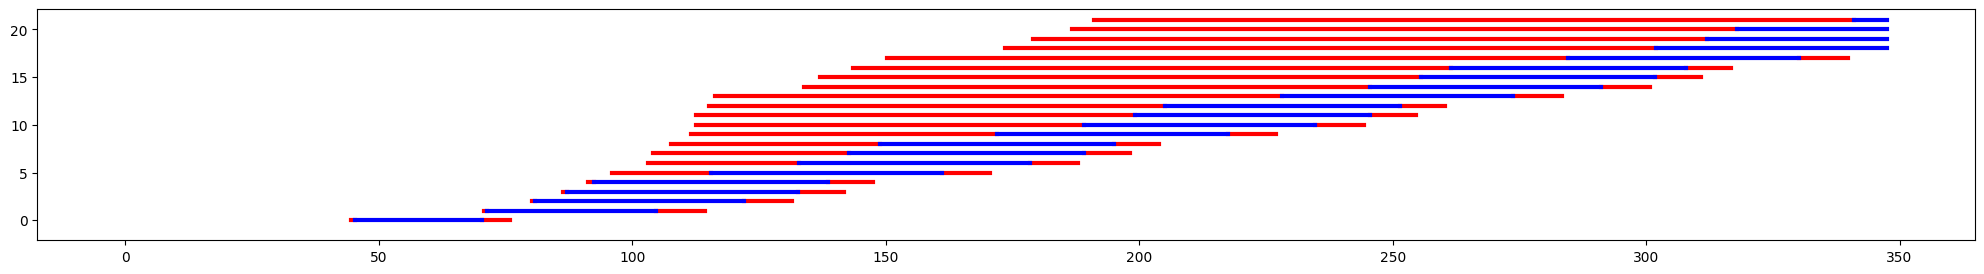

In [17]:
# PRINT SIMULATION RESULTS
FIRST = ITERATIONS

maxx = 0
timeouts = 0
for flow in list(sim.history.keys())[:FIRST]:
    if sim.history[flow]["status"] == 2:
        timeouts += 1
    else:
        task_list = list(sim.history[flow].keys())
        del task_list[0]
        for task in task_list:
            x = sim.history[flow][task].copy()
            #print(x)
            if len(x) % 2 == 0:
                x.append(sim.t)
            if len(x) > 1:
                del x[1]
                #print(x)
                y = len(x)*[flow]
                for i in range(0,len(x),2):
                    plt.plot(x[i:i+2], y[i:i+2], color=colors[app.task_graph.nodes[task]["subset"]],label = "Flow: "+str(flow)+", Task: "+str(task), linewidth=3)
            maxx = max(maxx,x[-1])
print("Success rate: "+str(int(100*(1-timeouts/len(sim.history))))+"%")
plt.rcParams["figure.figsize"] = (25,3)
#plt.legend()
plt.plot([0,maxx],2*[-1], color="white")
plt.show()

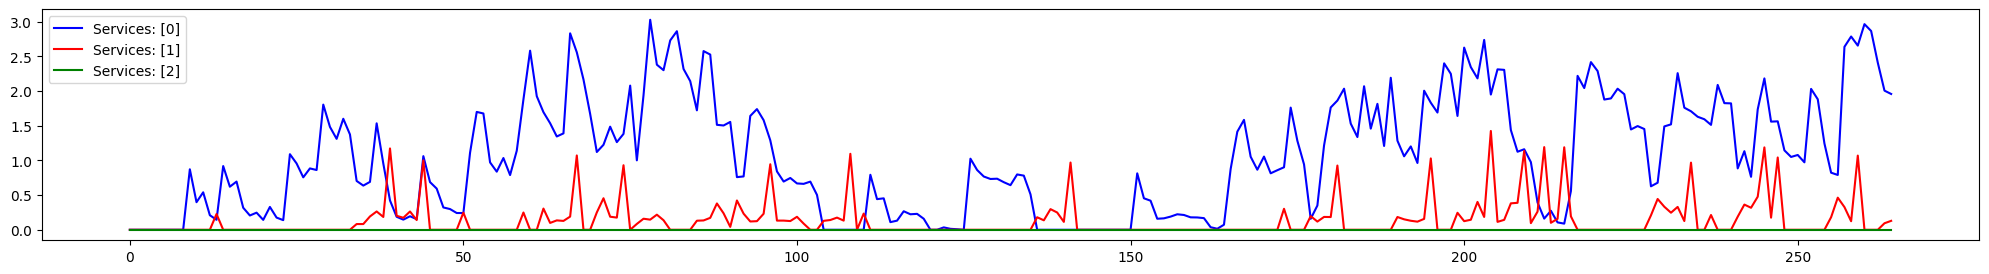

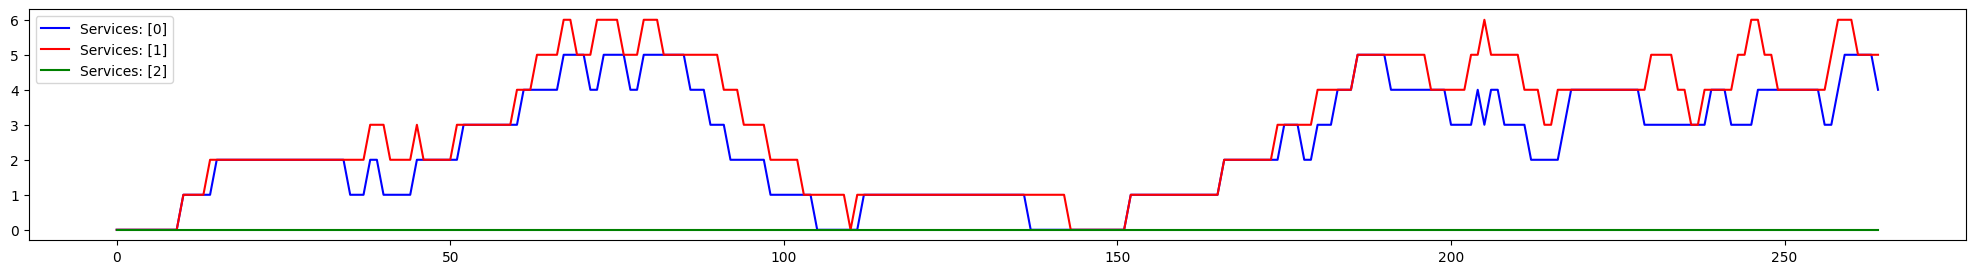

In [11]:
for s in app.services:
    plt.plot(range(int(sim.t)),s.node.mem_metric[:int(sim.t)], color=colors[s.id], label = "Services: "+str([ss.id for ss in app.services if ss.node.id == s.node.id]))
plt.legend()
plt.show()

for s in app.services:
    plt.plot(range(int(sim.t)),s.node.cpu_metric[:int(sim.t)], color=colors[s.id], label = "Services: "+str([ss.id for ss in app.services if ss.node.id == s.node.id]))
plt.legend()
plt.show()

In [ ]:
for s in app.services:
    x = [p[1] for p in s.queue_analytics]
    y = [p[0] for p in s.queue_analytics]
    x.append(sim.t)
    y.insert(0,0)
    plt.step(x, y, color=colors[s.id],label = "Service: "+str(s.id))
    plt.legend()
    plt.show()
for s in app.services:
    x= []
    y = []
    ss = 0
    for p in s.queue_analytics:
        x.append(p[1])
        ss += p[0]
        y.append(ss)
    x.append(sim.t)
    y.insert(0,0)
    plt.step(x, y, color=colors[s.id],label = "Service: "+str(s.id))
plt.legend()
plt.show()

In [ ]:
# PRINT TRACES

for flow in sim.history.keys():
    for task in sim.history[flow].keys():
        xx = sim.history[flow][task]
        if len(xx) % 2 == 1:
            xx.append(sim.t)
        x = xx[0:1]
        x.append(xx[-1])
        if app.tasks[task].depth == 0:
            x_root = x
        y = 2*[app.tasks[task].depth]
        plt.plot(x, y, color=colors[app.task_graph.nodes[task]["subset"]],label = "Flow: "+str(flow)+", Task: "+str(task), linewidth=25)
    plt.plot(x_root,2*[-1], color="white")
    print(app.tasks[task].depth+1)
    plt.plot(x_root,2*[app.tasks[task].depth+2], color="white")
    plt.show()

In [ ]:
data = {}
for s in app.services:
    numbers = s.CU.cpu_metric
    window_size = ITERATIONS
    i = 0
    moving_averages = []
    while i < len(numbers) - window_size + 1:
        this_window = numbers[i : i + window_size]
        window_average = sum(this_window) / window_size
        moving_averages.append(window_average)
        i += 1
    data[s.id] = s.CU.cpu_metric
    plt.plot(range(len(moving_averages)),[cc for cc in moving_averages], color=colors[s.id], label = "Services: "+str([ss.id for ss in app.services if ss.CU.id == s.CU.id]))
#plt.legend()
    plt.show()

In [ ]:
import pandas as pd
df = pd.DataFrame(data,columns=[s.id for s in app.services])
df.corr()

In [ ]:
for s in app.services:
    plt.plot(s.CU.mem_metric[:int(sim.t)],color=colors[s.id])
    plt.show()

# Extensions

*   Multiple threads per processor - **Done**
*   Queue monitoring - **Done**
*   CPU usage - **Done**
*   Enable simulation replay - **Done**
*   Initialize app state in simulation, not in app creation - **Done**
*   Implement app in a trace-like distributed app (task sending request and completing after response arrives) - **Done**
*   Multiple app support
*   Queue item removal after request times out
*   Queue upper limit
*   Bytes transferred metric
*   Interfaces for dynamic modification of deployment - **Running**
*   Create interfaces for adding custom apps (not only randomly generated) - **Running**
*   Support IO-bound subtasks - **partially Done**









# Tests

In [ ]:
mu,sigma = 0, 0.1
s = np.random.normal(mu, sigma, 1000)
print(s.tolist())
print(abs(mu - np.mean(s)))
print(abs(sigma - np.std(s, ddof=1)))

In [ ]:
from numpy import random
import matplotlib.pyplot as plt
import seaborn as sns

lam = 10
num = 100000
l = [- np.log(np.random.random()) / lam]
for p in range(num):
    l.append(l[-1] - np.log(np.random.random()) / lam)

pp = []
index = 0
interval = 1
t = interval
while t < l[-1]:
    count = 0
    while t >= l[index]:
        count += 1
        index += 1
    pp.append(count)
    t += interval
sns.histplot(pp, kde=True)
plt.show()

In [ ]:
from numpy import random
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(random.poisson(lam=10, size=10000), kde=True)

plt.show()

In [ ]:
count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
    np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
    linewidth=2, color='r')
plt.show()